# Regression Analysis – Distances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm



Load the distances dataset (DV), the correlations dataset (party-press alignment - IV), and the those for the controls (polling data and seat shares in EP and French parliament).

In [2]:
clim_distances = pd.read_csv('CLIM_distances_between_classes_across_time.csv')
imm_distances = pd.read_csv('IMM_distances_between_classes_across_time.csv')
corr = pd.read_csv('5_media_party_class_salience_CORRELATION_across_time.csv')
trends = pd.read_csv('Gtrends_imm_clim_2017_2019.csv')
poll = pd.read_csv('/Users/giovanni/masterthesis/4_Datasets/8_PollingData/FR_parties_seats_polls_classes_2017-2019.csv')

Create "same side", "opposite side", "centre" categories for the regressions in the correlations dataset

In [11]:
corr.dropna(inplace=True)
corr.reset_index(drop=True,inplace=True)

In [12]:
corr['side'] = None

for index, row in corr.iterrows():
    if row['media_leaning'] == row['party_leaning']:
        corr.at[index, 'side'] = 'same'
    elif ('left' in row['media_leaning']) and ('left' in row['party_leaning']):
        corr.at[index, 'side'] = 'same'
    elif ('right' in row['media_leaning']) and ('right' in row['party_leaning']): 
        corr.at[index, 'side'] = 'same'
    elif 'centre' in row['media_leaning'] or 'centre' in row['party_leaning']: 
        corr.at[index, 'side'] = 'centre'
    else: 
        corr.at[index, 'side'] = 'opposite'

Prepare data for the regressions – we hereby create one dataset with all the variables that we need for immigration and one for climate change

Step 1 - merge distances and party-press alignment (and clean)

In [13]:
basic_cols = ['time_period','leaning1','leaning2','side']
merged_df = pd.merge(corr, imm_distances, left_on=['time_period', 'media_leaning', 'party_leaning'], 
                     right_on=['timeperiod','leaning1','leaning2'],how='inner')
merged_df['distance_imm'] = merged_df['distance']
imm_columns = [col for col in merged_df.columns if 'imm' in col]
imm_columns = basic_cols+imm_columns
imm = merged_df[imm_columns]
imm.dropna(inplace=True)

merged_df = pd.merge(corr, clim_distances, left_on=['time_period', 'media_leaning', 'party_leaning'], 
                     right_on=['timeperiod','leaning1','leaning2'],how='inner')
merged_df['distance_clim'] = merged_df['distance']
clim_columns = [col for col in merged_df.columns if 'clim' in col]
clim_columns = basic_cols+clim_columns
clim = merged_df[clim_columns]
clim.dropna(inplace=True)

/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_2741/4081522281.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imm.dropna(inplace=True)
/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_2741/4081522281.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim.dropna(inplace=True)


Step 2 – add online salience through google trends

In [14]:
clim = pd.merge(clim,trends[['time_period','gtrend_salience_clim']],on='time_period')
imm = pd.merge(imm,trends[['time_period','gtrend_salience_imm']],on='time_period')

Step 3 – clean and add parliamentary seat shares and polling data for the political parties across the political spectrum 

In [15]:
def subset_df_politics():
    new_df = pd.DataFrame()
    
    for period in list(poll['time_period'].unique()): 
        temp_dic = {}
        temp_dic = {'time_period' : [period]}
    
        for leaning in list(leanings['leaning'].unique()):
            filtered_rows = poll[(poll['leaning'] == leaning) & (poll['time_period'] == period)]
            if not filtered_rows.empty:
                    
                ep = filtered_rows['ep_share'].values[0]
                parliament = filtered_rows['parliament_share'].values[0]
                polls = filtered_rows['poll_value'].values[0]
                temp_dic.update({f'{leaning}_ep' : [ep],
                                f'{leaning}_parliament' : [parliament],
                                f'{leaning}_poll' : [polls]})    
            
        row = pd.DataFrame(temp_dic)
        new_df = pd.concat([new_df, row], ignore_index = True)
        
    new_df.sort_values(by='time_period', inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    
    return new_df

In [16]:
poll=poll.groupby(['leaning','time_period'])[['poll_value','ep_share','parliament_share']].sum().reset_index()    
poll=subset_df_politics()

In [17]:
poll['time_period'] = poll['time_period'].apply(int)
for column in poll.loc[:, poll.columns != 'time_period'].columns:
    imm[column] = imm['time_period'].map(poll.set_index('time_period')[column])
    clim[column] = clim['time_period'].map(poll.set_index('time_period')[column])

Add the dates for tiem variance analysis

In [18]:
imm['date'] = imm.time_period.map(timeperiods.set_index('time_period')['start_date'])
clim['date'] = clim.time_period.map(timeperiods.set_index('time_period')['start_date'])

Step 4 – Add alignment variables

In [19]:
time_side_imm = imm.groupby(['time_period','side'])['imm_alignment'].mean().reset_index()
time_side_clim = clim.groupby(['time_period','side'])['clim_alignment'].mean().reset_index()

In [20]:
pivot_df = time_side_imm.pivot(index='time_period', columns='side', values='imm_alignment')
imm = pd.merge(imm, pivot_df, on='time_period').rename(columns={
    'centre': 'imm_alignment_centre',
    'same': 'imm_alignment_same_side',
    'opposite': 'imm_alignment_opposite_side'
})

pivot_df = time_side_clim.pivot(index='time_period', columns='side', values='clim_alignment')
clim = pd.merge(clim, pivot_df, on='time_period').rename(columns={
    'centre': 'clim_alignment_centre',
    'same': 'clim_alignment_same_side',
    'opposite': 'clim_alignment_opposite_side'
})



Step 6 - add network statistics

In [21]:
ntk_stats_imm = pd.DataFrame(df[['time_period','imm_modularity','imm_nodes_number','imm_edges_number']].groupby('time_period').mean()[['imm_modularity','imm_nodes_number','imm_edges_number']].reset_index())
ntk_stats_clim = pd.DataFrame(df[['time_period','clim_modularity','clim_nodes_number','clim_edges_number']].groupby('time_period').mean()[['clim_modularity','clim_nodes_number','clim_edges_number']].reset_index())

In [22]:
imm['nodes_number'] = imm.time_period.map(ntk_stats_imm.set_index('time_period')['imm_nodes_number'])
imm['edges_number']= imm.time_period.map(ntk_stats_imm.set_index('time_period')['imm_edges_number'])
imm['modularity']= imm.time_period.map(ntk_stats_imm.set_index('time_period')['imm_modularity'])

clim['nodes_number']= clim.time_period.map(ntk_stats_clim.set_index('time_period')['clim_nodes_number'])
clim['edges_number']= clim.time_period.map(ntk_stats_clim.set_index('time_period')['clim_edges_number'])
clim['modularity']= clim.time_period.map(ntk_stats_clim.set_index('time_period')['clim_modularity'])

Step 7 - save to csv file

In [23]:
imm.to_csv('imm_df_regression_FINAL.csv', index= False)
clim.to_csv('clim_df_regression_FINAL.csv', index= False)

In [24]:
imm.head()

,time_period,leaning1,leaning2,side,imm_alignment,imm_media_salience,imm_party_salience,distance_imm,gtrend_salience_imm,right_ep,...,centre-left_ep,centre-left_parliament,centre-left_poll,date,imm_alignment_centre,imm_alignment_opposite_side,imm_alignment_same_side,nodes_number,edges_number,modularity
0,1,left,left,same,0.000590,0.028436,0.020747,15.294672,0.226804,0.324324,...,0.108108,0.006932,0.132500,2017-01-01,0.000164,NaN,0.000493,25.0,24.0,0.502604
1,1,centre-left,left,same,0.000396,0.019097,0.020747,25.587339,0.226804,0.324324,...,0.108108,0.006932,0.132500,2017-01-01,0.000164,NaN,0.000493,25.0,24.0,0.502604
2,1,centre,left,centre,0.000164,0.007905,0.020747,18.881087,0.226804,0.324324,...,0.108108,0.006932,0.132500,2017-01-01,0.000164,NaN,0.000493,25.0,24.0,0.502604
3,3,left,left,same,0.000025,0.007067,0.003540,0.000000,0.927835,0.324324,...,0.054054,0.003466,0.052857,2017-01-29,0.000010,NaN,0.000032,24.0,26.0,0.493343
4,3,centre-left,left,same,0.000040,0.011189,0.003540,17.285946,0.927835,0.324324,...,0.054054,0.003466,0.052857,2017-01-29,0.000010,NaN,0.000032,24.0,26.0,0.493343


In [266]:
clim.head()

,time_period,leaning1,leaning2,side,clim_alignment,clim_media_salience,clim_party_salience,distance_clim,gtrend_salience_clim,right_ep,...,centre-right_ep,centre-right_parliament,centre-right_poll,centre-left_ep,centre-left_parliament,centre-left_poll,date,clim_alignment_centre,clim_alignment_opposite_side,clim_alignment_same_side
0,1,left,left,same,0.000472,0.028436,0.016598,0.000000,19.5,0.324324,...,0.27027,0.336222,0.245,0.108108,0.006932,0.13250,2017-01-01,0.000394,NaN,0.000409
1,1,centre-left,left,same,0.000346,0.020833,0.016598,14.740678,19.5,0.324324,...,0.27027,0.336222,0.245,0.108108,0.006932,0.13250,2017-01-01,0.000394,NaN,0.000409
2,1,centre,left,centre,0.000394,0.023715,0.016598,14.145180,19.5,0.324324,...,0.27027,0.336222,0.245,0.108108,0.006932,0.13250,2017-01-01,0.000394,NaN,0.000409
3,2,left,left,same,0.000409,0.030973,0.013193,6.075613,17.5,0.324324,...,0.27027,0.336222,0.245,0.054054,0.003466,0.06625,2017-01-15,NaN,NaN,0.000292
4,2,centre-left,left,same,0.000174,0.013223,0.013193,8.667359,17.5,0.324324,...,0.27027,0.336222,0.245,0.054054,0.003466,0.06625,2017-01-15,NaN,NaN,0.000292


We now have two dataframes with all of the main variables and controls we need for the regression analysis. We turn to plot the IV and DV to identify any strange behaviour in their evolution through time.

# Plot IV and DV

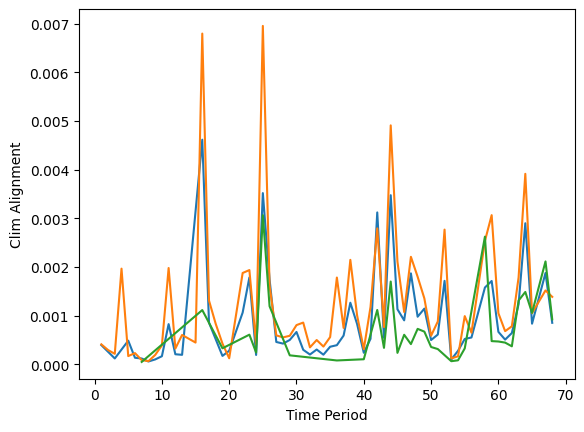

In [25]:
trend = clim.groupby(['time_period', 'side'])['clim_alignment'].mean().reset_index()  # You can also use .median() if you prefer

unique_sides = trend['side'].unique()

# Plotting each side separately
for side in unique_sides:
    # Filtering data for the current side
    side_data = trend[trend['side'] == side]
    
    # Plotting the trend for the current side
    plt.plot(side_data['time_period'], side_data['clim_alignment'], label=side)
# Adding labels
plt.xlabel('Time Period')
plt.ylabel('Clim Alignment')

# Showing the plot
plt.show()

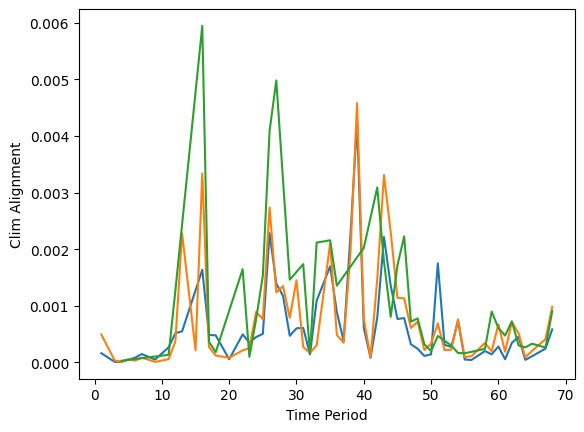

In [183]:
trend = imm.groupby(['time_period', 'side'])['imm_alignment'].mean().reset_index()  # You can also use .median() if you prefer

unique_sides = trend['side'].unique()

# Plotting each side separately
for side in unique_sides:
    # Filtering data for the current side
    side_data = trend[trend['side'] == side]
    
    # Plotting the trend for the current side
    plt.plot(side_data['time_period'], side_data['imm_alignment'], label=side)
# Adding labels
plt.xlabel('Time Period')
plt.ylabel('Clim Alignment')

# Showing the plot
plt.show()

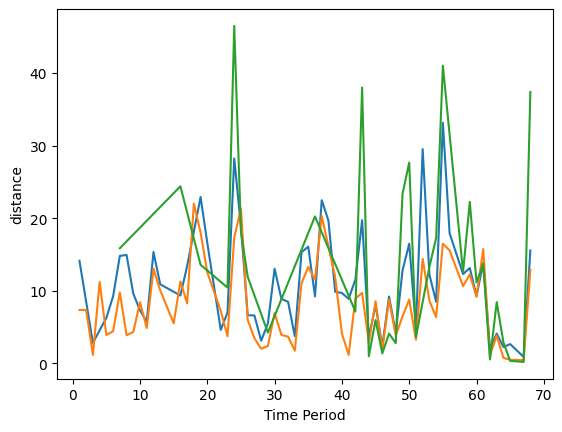

In [184]:
trend = clim.groupby(['time_period', 'side'])['distance_clim'].mean().reset_index()  # You can also use .median() if you prefer

unique_sides = trend['side'].unique()

# Plotting each side separately
for side in unique_sides:
    # Filtering data for the current side
    side_data = trend[trend['side'] == side]
    
    # Plotting the trend for the current side
    plt.plot(side_data['time_period'], side_data['distance_clim'], label=side)
# Adding labels
plt.xlabel('Time Period')
plt.ylabel('distance')

# Showing the plot
plt.show()

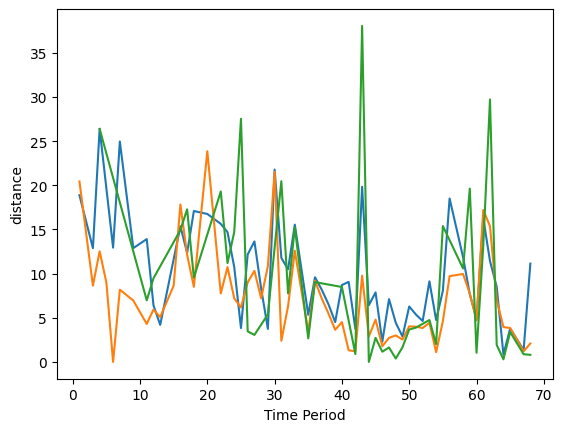

In [185]:
trend = imm.groupby(['time_period', 'side'])['distance_imm'].mean().reset_index()  # You can also use .median() if you prefer

unique_sides = trend['side'].unique()

# Plotting each side separately
for side in unique_sides:
    # Filtering data for the current side
    side_data = trend[trend['side'] == side]
    
    # Plotting the trend for the current side
    plt.plot(side_data['time_period'], side_data['distance_imm'], label=side)
# Adding labels
plt.xlabel('Time Period')
plt.ylabel('distance')

# Showing the plot
plt.show()

We now check for time-related variance using an ARIMA model. 

In [26]:
series = imm[['distance_imm','date']].set_index('date')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

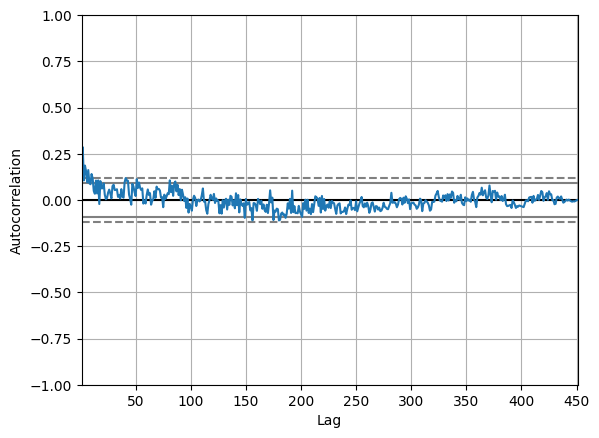

In [27]:
autocorrelation_plot(series)

In [28]:
series = clim[['distance_clim','date']].set_index('date')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

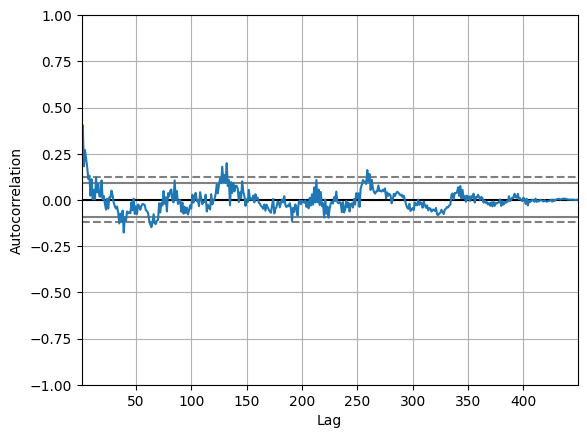

In [29]:
autocorrelation_plot(series)

# Regressions

We now turn to the construction of the regression models. 

In [30]:
imm.columns

Index(['time_period', 'leaning1', 'leaning2', 'side', 'imm_alignment',
       'imm_media_salience', 'imm_party_salience', 'distance_imm',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'date',
       'imm_alignment_centre', 'imm_alignment_opposite_side',
       'imm_alignment_same_side', 'nodes_number', 'edges_number',
       'modularity'],
      dtype='object')

In [32]:
same_side_imm = imm[imm['side']=='same']
centre_imm = imm[imm['side']=='centre']
opposite_imm = imm[imm['side']=='opposite']

same_side_clim = clim[clim['side']=='same']
centre_clim = clim[clim['side']=='centre']
opposite_clim = clim[clim['side']=='opposite']

## Full Regression Tables

### General Distances

In [305]:
x = imm[[ 'imm_alignment_opposite_side',
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_gen = model.fit()
print(model_imm_gen.summary())

                            OLS Regression Results                            
Dep. Variable:           distance_imm   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     6.356
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           1.49e-14
Time:                        20:05:49   Log-Likelihood:                -1512.0
No. Observations:                 451   AIC:                             3064.
Df Residuals:                     431   BIC:                             3146.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [300]:
x = clim[[ 'clim_alignment_opposite_side',
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          distance_clim   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     5.182
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           2.86e-11
Time:                        20:00:12   Log-Likelihood:                -1606.1
No. Observations:                 449   AIC:                             3252.
Df Residuals:                     429   BIC:                             3334.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Same Side Regression

In [295]:
x = same_side_imm[[ 'imm_alignment_opposite_side',
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = same_side_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           distance_imm   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     2.346
Date:                Thu, 25 Apr 2024   Prob (F-statistic):            0.00218
Time:                        19:56:33   Log-Likelihood:                -596.68
No. Observations:                 180   AIC:                             1233.
Df Residuals:                     160   BIC:                             1297.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [294]:
x = same_side_clim[[ 'clim_alignment_opposite_side',
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = same_side_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          distance_clim   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     2.212
Date:                Thu, 25 Apr 2024   Prob (F-statistic):            0.00397
Time:                        19:55:54   Log-Likelihood:                -652.72
No. Observations:                 188   AIC:                             1345.
Df Residuals:                     168   BIC:                             1410.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Opposite side regressions

In [293]:
x = opposite_imm[['imm_alignment_opposite_side',
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = opposite_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           distance_imm   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     3.355
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           0.000718
Time:                        19:55:43   Log-Likelihood:                -195.27
No. Observations:                  60   AIC:                             426.5
Df Residuals:                      42   BIC:                             464.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [296]:
x = opposite_clim[[ 'clim_alignment_opposite_side',
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = opposite_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          distance_clim   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     2.212
Date:                Thu, 25 Apr 2024   Prob (F-statistic):            0.00397
Time:                        19:56:56   Log-Likelihood:                -652.72
No. Observations:                 188   AIC:                             1345.
Df Residuals:                     168   BIC:                             1410.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Centre regressions

In [298]:
x = centre_imm[[ 'imm_alignment_opposite_side',
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = centre_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           distance_imm   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     4.507
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           2.15e-08
Time:                        19:58:04   Log-Likelihood:                -679.22
No. Observations:                 211   AIC:                             1398.
Df Residuals:                     191   BIC:                             1465.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [297]:
x = centre_clim[[ 'clim_alignment_opposite_side',
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = centre_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          distance_clim   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     2.212
Date:                Thu, 25 Apr 2024   Prob (F-statistic):            0.00397
Time:                        19:57:40   Log-Likelihood:                -652.72
No. Observations:                 188   AIC:                             1345.
Df Residuals:                     168   BIC:                             1410.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Regressions breakdowns

### IMMIGRATION

In this section I wanted to see how incrementally adding variables influenced the output of the model. 

In [33]:
x = imm[[
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_gen_control = model.fit()

x = imm[['imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_gen_control_centre = model.fit()

x = imm[[
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_gen_control_centre_same = model.fit()

x = imm[['imm_alignment_opposite_side',
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_gen_full = model.fit()


In [34]:
x = same_side_imm[[
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = same_side_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_same_control = model.fit()

x = same_side_imm[['imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = same_side_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_same_control_centre = model.fit()

x = same_side_imm[[
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = same_side_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_same_control_centre_same = model.fit()

x = same_side_imm[['imm_alignment_opposite_side',
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = same_side_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_same_full = model.fit()



In [35]:
x = opposite_imm[[
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = opposite_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_opposite_control = model.fit()

x = opposite_imm[['imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = opposite_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_opposite_control_centre = model.fit()

x = opposite_imm[[
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = opposite_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_opposite_control_centre_same = model.fit()

x = opposite_imm[['imm_alignment_opposite_side',
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = opposite_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_opposite_full = model.fit()



In [36]:
x = centre_imm[[
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = centre_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_centre_control = model.fit()

x = centre_imm[['imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = centre_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_centre_control_centre = model.fit()

x = centre_imm[[
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = centre_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_centre_control_centre_same = model.fit()

x = centre_imm[['imm_alignment_opposite_side',
       'imm_alignment_same_side','imm_alignment_centre',
       'imm_media_salience', 'imm_party_salience',
       'gtrend_salience_imm', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll','nodes_number', 'edges_number']]
y = centre_imm['distance_imm']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_imm_centre_full = model.fit()



In [37]:
regression_models = [model_imm_gen_control, model_imm_gen_control_centre, 
                     model_imm_gen_control_centre_same,model_imm_gen_full,
                    model_imm_same_control, model_imm_same_control_centre, 
                     model_imm_same_control_centre_same,model_imm_same_full,
                    model_imm_opposite_control, model_imm_opposite_control_centre, 
                     model_imm_opposite_control_centre_same,model_imm_opposite_full,
                    model_imm_centre_control, model_imm_centre_control_centre, 
                     model_imm_centre_control_centre_same,model_imm_centre_full,]  # Add your models here

# List of model names for printing
model_names = ["Average Distances - Immigration","Average Distances - Immigration","Average Distances - Immigration","Average Distances - Immigration",
              # "Average Distances - Climate",
               "Same side distances - Immigration", "Same side distances - Immigration", "Same side distances - Immigration", "Same side distances - Immigration", 
              # 'Same side distances - Climate'
              "Opposite side distances - Immigration","Opposite side distances - Immigration","Opposite side distances - Immigration","Opposite side distances - Immigration", 
              "Centre distances - Immigration","Centre distances - Immigration","Centre distances - Immigration","Centre distances - Immigration"]



In [40]:
def create_coefficient_summary(model, model_name):
    coefficients = pd.DataFrame({
        "Coefficient Name": model.params.index,
        "Coefficient": model.params.values.round(2),
        "Standard Error": model.bse.values.round(2),
        "p-value": model.pvalues.values
    })
    coefficients['Significance'] = ''
    coefficients.loc[coefficients['p-value'] < 0.1, 'Significance'] = '*'
    coefficients.loc[coefficients['p-value'] < 0.05, 'Significance'] = '**'
    coefficients.loc[coefficients['p-value'] < 0.01, 'Significance'] = '***'
    coefficients['Coefficient'] = coefficients.apply(lambda row: f"{row['Coefficient']} {row['Significance']}", axis=1)
    coefficients.drop(columns=['Significance'], inplace=True)
    coefficients.index.name = model_name
    return coefficients

# Iterate over models and print summaries
for i, model in enumerate(regression_models):
    coefficient_summary = create_coefficient_summary(model, model_names[i])
    print('---------------------------------------------------------------')
    print(f"Summary for {model_names[i]}:")
    print(coefficient_summary.to_string(index=False))
    print('rsquared:', model.rsquared)
    print()  # Adding an empty line for better readability between models


---------------------------------------------------------------
Summary for Average Distances - Immigration:
       Coefficient Name Coefficient  Standard Error  p-value
                  const    1159.44          3847.43 0.763289
     imm_media_salience    -65.15 *           33.65 0.053488
     imm_party_salience      -1.35             8.04 0.866738
    gtrend_salience_imm      -4.12             2.61 0.115438
               right_ep      363.9          1200.35 0.761911
       right_parliament    1049.32          3376.38 0.756114
             right_poll   90.82 ***           21.42 0.000027
              centre_ep     127.38           498.45 0.798420
      centre_parliament   -2123.07          6885.52 0.757973
            centre_poll   41.58 ***           12.18 0.000703
                left_ep      88.55           196.91 0.653149
        left_parliament   -2788.41          9099.76 0.759427
              left_poll      -16.9            12.89 0.190459
        centre-right_ep     240.57   

### CLIMATE

In [41]:
x = clim[['clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_gen_control = model.fit()

x = clim[[ 'clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_gen_control_centre = model.fit()

x = clim[[ 
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_gen_control_centre_same = model.fit()

x = clim[[ 'clim_alignment_opposite_side',
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_gen_full = model.fit()



In [42]:
x = same_side_clim[['clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = same_side_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_same_control = model.fit()

x = same_side_clim[[ 'clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = same_side_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_same_control_centre = model.fit()

x = same_side_clim[[ 
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = same_side_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_same_control_centre_same = model.fit()

x = same_side_clim[[ 'clim_alignment_opposite_side',
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = same_side_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_same_full = model.fit()



In [43]:
x = opposite_clim[['clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = opposite_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_opposite_control = model.fit()

x = opposite_clim[[ 'clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = opposite_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_opposite_control_centre = model.fit()

x = opposite_clim[[ 
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = opposite_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_opposite_control_centre_same = model.fit()

x = opposite_clim[[ 'clim_alignment_opposite_side',
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = opposite_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_opposite_full = model.fit()


In [44]:
x = centre_clim[['clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = centre_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_centre_control = model.fit()

x = centre_clim[[ 'clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = centre_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_centre_control_centre = model.fit()

x = centre_clim[[ 
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = centre_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_centre_control_centre_same = model.fit()

x = centre_clim[[ 'clim_alignment_opposite_side',
       'clim_alignment_same_side','clim_alignment_centre','clim_media_salience', 'clim_party_salience',
       'gtrend_salience_clim', 'right_ep', 'right_parliament', 'right_poll',
       'centre_ep', 'centre_parliament', 'centre_poll', 'left_ep',
       'left_parliament', 'left_poll', 'centre-right_ep',
       'centre-right_parliament', 'centre-right_poll', 'centre-left_ep',
       'centre-left_parliament', 'centre-left_poll', 'nodes_number', 'edges_number']]
y = centre_clim['distance_clim']
x = sm.add_constant(x)

model = sm.OLS(y, x)
model_clim_centre_full = model.fit()



In [45]:
regression_models = [model_clim_gen_control, model_clim_gen_control_centre, 
                     model_clim_gen_control_centre_same,model_clim_gen_full,
                    model_clim_same_control, model_clim_same_control_centre, 
                     model_clim_same_control_centre_same,model_clim_same_full,
                    model_clim_opposite_control, model_clim_opposite_control_centre, 
                     model_clim_opposite_control_centre_same,model_clim_opposite_full,
                    model_clim_centre_control, model_clim_centre_control_centre, 
                     model_clim_centre_control_centre_same,model_clim_centre_full,]  # Add your models here

# List of model names for printing
model_names = ["Average Distances - Climate","Average Distances - Climate","Average Distances - Climate","Average Distances - Climate",
               "Same side distances - Climate", "Same side distances - Climate", "Same side distances - Climate", "Same side distances - Climate", 
              "Opposite side distances - Climate","Opposite side distances - Climate","Opposite side distances - Climate","Opposite side distances - Climate", 
              "Centre distances - Climate","Centre distances - Climate","Centre distances - Climate","Centre distances - Climate"]




In [46]:
def create_coefficient_summary(model, model_name):
    coefficients = pd.DataFrame({
        "Coefficient Name": model.params.index,
        "Coefficient": model.params.values.round(2),
        "Standard Error": model.bse.values.round(2),
        "p-value": model.pvalues.values
    })
    coefficients['Significance'] = ''
    coefficients.loc[coefficients['p-value'] < 0.1, 'Significance'] = '*'
    coefficients.loc[coefficients['p-value'] < 0.05, 'Significance'] = '**'
    coefficients.loc[coefficients['p-value'] < 0.01, 'Significance'] = '***'
    coefficients['Coefficient'] = coefficients.apply(lambda row: f"{row['Coefficient']} {row['Significance']}", axis=1)
    coefficients.drop(columns=['Significance'], inplace=True)
    coefficients.index.name = model_name
    return coefficients

# Iterate over models and print summaries
for i, model in enumerate(regression_models):
    coefficient_summary = create_coefficient_summary(model, model_names[i])
    print('---------------------------------------------------------------')
    print(f"Summary for {model_names[i]}:")
    print(coefficient_summary.to_string(index=False))
    print('rsquared:', model.rsquared)
    print()  # Adding an empty line for better readability between models

---------------------------------------------------------------
Summary for Average Distances - Climate:
       Coefficient Name Coefficient  Standard Error  p-value
                  const     -74.83           215.49 0.728563
    clim_media_salience      26.85            42.96 0.532270
    clim_party_salience   24.09 ***            8.86 0.006802
   gtrend_salience_clim      -1.99             3.13 0.525383
               right_ep     -22.16            67.34 0.742275
       right_parliament    -147.99           201.21 0.462455
             right_poll      27.64            25.84 0.285349
              centre_ep     -22.15            28.29 0.434077
      centre_parliament     173.92           389.65 0.655565
            centre_poll    38.71 **           17.20 0.024909
                left_ep -105.09 ***           34.78 0.002664
        left_parliament     206.68           512.34 0.686858
              left_poll   -38.15 **           15.03 0.011464
        centre-right_ep      -7.57       